# Video Understanding

Video understanding presents significantly greater challenges than static image analysis due to the addition of temporal dynamics. Models must not only recognize objects and scenes within individual frames but also understand how they change, move, and interact over time.

## Key Challenges:

- Computational complexity: Processing multiple frames together requires substantially more memory and processing power
- Temporal context limitations: Most models can only analyze limited time windows, missing long-term patterns or dependencies

In this notebook, we will look at a video vision transformer-based model, called ViVit

In [1]:
import cv2
import matplotlib.pyplot as plt 

## Spatial and Temporal Dimensions

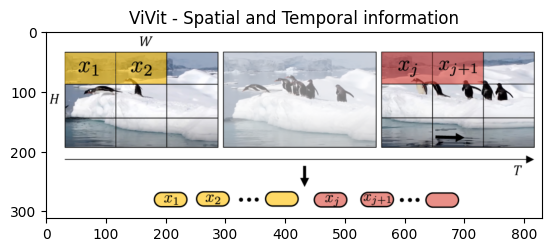

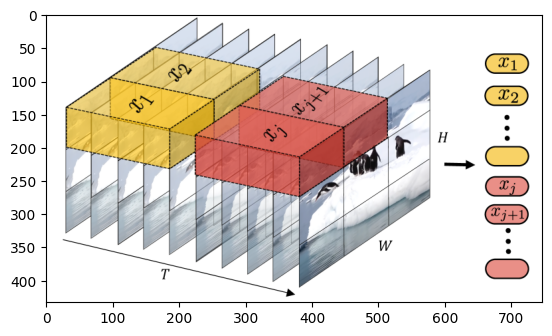

In [2]:
tubelet_spatial_path = "./assets/tubelet-spatial.png"
tubelet_temporal_path = "./assets/tubelet-temporal.png"

plt.title("ViVit - Spatial and Temporal information")
image = cv2.imread(tubelet_spatial_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

image = cv2.imread(tubelet_temporal_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [3]:
import av
import numpy as np
import torch

from transformers import VivitImageProcessor, VivitForVideoClassification, AutoImageProcessor, VideoMAEForVideoClassification

In [4]:
def read_video(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [5]:
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    temporal_window = int(clip_len * frame_sample_rate)
    
    # Handle edge case
    if seg_len <= temporal_window:
        return np.linspace(0, seg_len - 1, num=clip_len).astype(np.int64)
    
    end_idx = np.random.randint(temporal_window, seg_len)
    start_idx = end_idx - temporal_window
    
    indices = np.linspace(start_idx, end_idx - 1, num=clip_len).astype(np.int64)
    
    return indices

In [6]:
# image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
# https://gist.github.com/willprice/f19da185c9c5f32847134b87c1960769

video_paths = [
    "./assets/basketball-top-5.mp4",
    "./assets/dancing.mp4",
    "./assets/football.mp4",
    "./assets/pickleball.mp4"
]

In [12]:
video_path = video_paths[0]
print(f"Processing #{video_path}")

container = av.open(video_path)

indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video(container=container, indices=indices)

inputs = image_processor(list(video), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predicted_label = logits.argmax(-1).item()

print(f"{video_path} has label: {model.config.id2label[predicted_label]}")

Processing #./assets/basketball-top-5.mp4
./assets/basketball-top-5.mp4 has label: dunking basketball


## Limitations

- These models have a very small context window (8, 16, 32, 96 frames)
- Models are not generalisable
- Pre-trained datasets are very limited, specific to certain industries, and are not actively maintained 
- Training is expensive and requires significant amount of task-specific annotated data